In [ ]:
import os
os.chdir(os.path.expanduser('~/My Drive/dirclip-private/core'))

In [ ]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [3]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from functools import partial
from itertools import count
from glob import glob
from tqdm.auto import tqdm
from jax import vmap
from jax.tree_util import tree_map, tree_leaves
from os.path import expanduser
import models, datasets, distributions, utils

In [4]:
# load dataset
ds_name = 'cifar10'
x_train, y_train, n_class = datasets.load(ds_name, 'train')
x_test,  y_test,  n_class = datasets.load(ds_name, 'test')

In [5]:
def bootstrap_mean(key, data, n_samples=100):
    # generate data batches with replacement
    bootstrap_samples = jax.random.choice(key, data, (n_samples, len(data)), replace=True)
    
    # evaluate mean for each batch
    vals = vmap(jnp.mean)(bootstrap_samples)
    
    median = jnp.median(vals)
    lower = jnp.percentile(vals, 10)
    upper = jnp.percentile(vals, 90)
    return median.item(), lower.item(), upper.item()

def bootstrap_ens(key, logits, y, metric, sample_size=8, n_samples=100):
    """vectorized bootstrap sampling"""
    # generate data batches with replacement
    # bootstrap_samples = jax.random.choice(key, data, (n_samples, sample_size), replace=True)
    
    # generate data batches without replacement
    get_batches = lambda key: jax.random.choice(key, logits, [sample_size], replace=False)
    bootstrap_batches = vmap(get_batches)(jax.random.split(key, n_samples))

    # evaluate function for each batch
    if metric == 'acc': f = lambda logits: ens_acc(logits, y)
    if metric == 'like': f = lambda logits: ens_like(logits, y)
    vals = vmap(f)(bootstrap_batches)

    # return distribution summary (median ±1 st dev)
    median = jnp.median(vals)
    lower = jnp.percentile(vals, 10)
    upper = jnp.percentile(vals, 90)
    return median.item(), lower.item(), upper.item()

def sample_acc(logits, y):
    """
    logits.shape: [n_test, n_class]
    y.shape: [n_class]
    """
    logprobs = jax.nn.log_softmax(logits)
    acc = (logprobs.argmax(-1) == y).mean()
    return acc

def ens_acc(logits, y):
    logprobs = utils.average_predictions(logits)
    acc = (logprobs.argmax(-1) == y).mean()
    return acc

def sample_like(logits, y):
    logprobs = jax.nn.log_softmax(logits)
    _, n_class = logprobs.shape
    y_one_hot = jax.nn.one_hot(y, n_class)
    log_like = (y_one_hot * logprobs).sum()
    return log_like

def ens_like(logits, y):
    logprobs = utils.average_predictions(logits)
    _, n_class = logprobs.shape
    y_one_hot = jax.nn.one_hot(y, n_class)
    log_like = (y_one_hot * logprobs).sum()
    return log_like

def sample_conf(logits):
    return jax.nn.softmax(logits).max(-1).mean()

In [20]:
# load all models into a single list
key = jax.random.PRNGKey(0)
models_list = []
weights_paths = glob(expanduser('~/Downloads/weights/weights_misc/*seed=0*'))
weights_paths += glob(expanduser('~/Downloads/weights/weights_finetune_dirclip-50_10k/*seed=0*'))
for model_dir in tqdm(sorted(weights_paths)):
    
    # get model config
    model_name = model_dir.rsplit('/', 1)[1]
    config = eval(f'dict({model_name})')
    
    # load data for all seeds
    logits_train = []
    logits_test = []
    for i in count():
        seed_dir = f'{model_dir[:-1]}{i}'
        if not os.path.isdir(seed_dir): break
        logits_train += [jnp.load(f'{seed_dir}/logits_train.npy')]
        logits_test += [jnp.load(f'{seed_dir}/logits_test.npy')]
    logits_train = jnp.concatenate(logits_train)
    logits_test = jnp.concatenate(logits_test)
    ens_size = len(logits_train)

    # compute metrics
    key, key_acc_train, key_acc_test, key_like_train, key_like_test, key_conf_train = jax.random.split(key, 6)
    acc_train = bootstrap_mean(key_acc_train, vmap(partial(sample_acc, y=y_train))(logits_train))
    acc_test = bootstrap_ens(key_acc_test, logits_test, y_test, 'acc')
    like_train = bootstrap_mean(key_like_train, vmap(partial(sample_like, y=y_train))(logits_train))
    like_test = bootstrap_ens(key_like_test, logits_test, y_test, 'like')

    # save model to dataframe
    models_list += [{**config, **dict(acc_train=acc_train, acc_test=acc_test, like_train=like_train, like_test=like_test, ens_size=ens_size)}]

  0%|          | 0/77 [00:00<?, ?it/s]

In [21]:
# make pandas dataframe of models 
df = pd.DataFrame.from_dict(models_list)

# hack: all DirClip models are exactly identical at alpha=1, so there's no need to repeat these training runs
for clip_val in (20, 30): # -50
    row = df[(df.dist=='dirclip-10') & (df.dist_param==1) & (df.finetuned)].copy()
    row.dist = f'dirclip-{clip_val}'
    df = pd.concat([df, row])

In [22]:
# check that there are no models with <>24 posterior samples
df[(df.ens_size!=24)]

,model,ds,dist,dist_param,std,temp,augment,finetuned,seed,acc_train,acc_test,like_train,like_test,ens_size


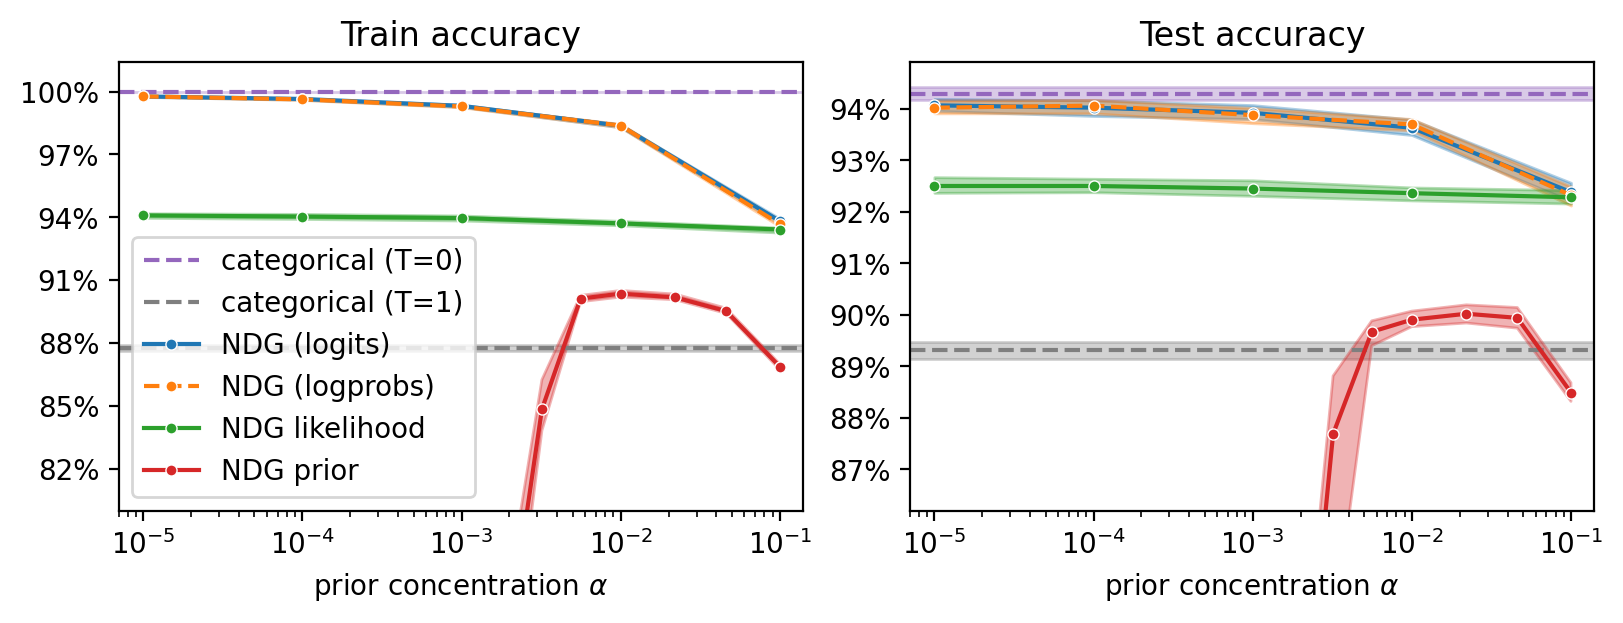

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), layout='constrained')

# either plot [prior confidence] or [posterior accuracy]
for ax, metric in zip(axs, ('acc_train', 'acc_test')):
    
    # categorical baseline
    for T, color in ( (0, 'tab:purple'), (1, 'tab:gray')):
        df_subset = df[(df.dist=='categorical') & (df.temp==T)]
        y = df_subset[metric].item()
        ax.axhline(y[0], color=color, ls='--', lw=1.5, label=f'categorical ({T=})')
        ax.fill_between([0, 1], y[1], y[2], alpha=0.35, color=color)
    
    # NDG
    to_plot = (
        ('ndg-logits', 'NDG (logits)', 'tab:blue'),
        ('ndg-logprobs', 'NDG (logprobs)', 'tab:orange'),
        ('ndg-likelihood', 'NDG likelihood', 'tab:green'),
        ('ndg-prior', 'NDG prior', 'tab:red'),
    )
    for i, (distribution, name, color) in enumerate(to_plot):
        df_subset = df[(df.dist==distribution) & (df.temp==1)]
        x = df_subset.dist_param.to_numpy()
        y = np.stack(df_subset[metric])
        o = np.argsort(x)[1:]
        ls = '.--' if distribution == 'ndg-logprobs' else '.-'
        ax.plot(x[o], y[o, 0], ls, label=name, mec='white', mew=0.5, ms=8, color=color)
        ax.fill_between(x[o], y[o, 1], y[o, 2], alpha=0.35, color=color)

for ax in axs:
    ax.set_xscale('log')
    ax.yaxis.set_major_formatter(lambda x, _: f'{x:.0%}')
    ax.set_xlabel(r'prior concentration $\alpha$')
    ax.set_xlim((7e-6, 0.14))
axs[0].set_ylim((0.8, 1.014))
axs[1].set_ylim((0.862, 0.949))
axs[0].set_yticks(np.arange(0.82, 1.01, 0.03))
axs[1].set_yticks(np.arange(0.87, 0.941, 0.01))

# titles
axs[0].set_title('Train accuracy')
axs[1].set_title('Test accuracy')

axs[0].legend(loc='lower left')
# plt.savefig('../plots/ndg_accuracy.pdf')
plt.show()

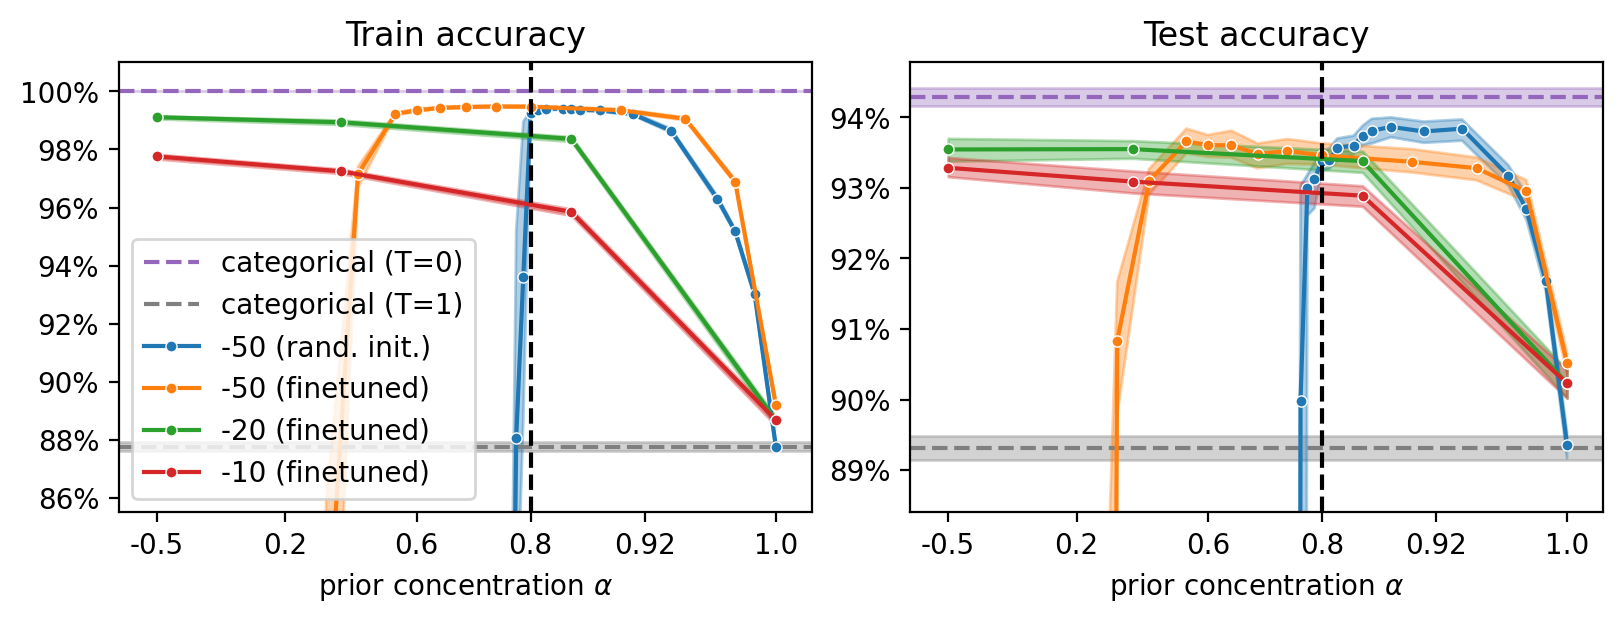

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), layout='constrained')

# either plot [prior confidence] or [posterior accuracy]
for ax, metric in zip(axs, ('acc_train', 'acc_test')):
    
    # categorical baseline
    for T, color in ((0, 'tab:purple'), (1, 'tab:gray')):
        df_subset = df[(df.dist=='categorical') & (df.temp==T)]
        y = df_subset[metric].item()
        ax.axhline(y[0], color=color, ls='--', lw=1.5, label=f'categorical ({T=})')
        ax.fill_between([-1, 1.05], y[1], y[2], alpha=0.35, color=color)
    
    to_plot = (
        ('dirclip-50', False, '-50 (rand. init.)'),
        ('dirclip-50', True, '-50 (finetuned)'),
        ('dirclip-20', True, '-20 (finetuned)'),
        ('dirclip-10', True, '-10 (finetuned)'),
    )
    for i, (distribution, finetuned, name) in enumerate(to_plot):
        df_subset = df[(df.dist==distribution) & (df.temp==1) & (df.finetuned==finetuned)]
        x = df_subset.dist_param.to_numpy()
        y = np.stack(df_subset[metric])
        o = np.argsort(x)
        color = f'C{i+(i>=4)}'
        ax.plot(x[o], y[o, 0], '.-', label=name, mec='white', mew=0.5, ms=8, color=color)
        ax.fill_between(x[o], y[o, 1], y[o, 2], alpha=0.35, color=color)

# titles
axs[0].set_title('Train accuracy')
axs[1].set_title('Test accuracy')

# y limits
axs[0].set_ylim((0.855, 1.01))
axs[1].set_ylim((0.884, 0.9478))

for ax in axs:
    ax.set_xscale(mpl.scale.FuncScale(ax, (lambda x: -jnp.log(1.1-x), lambda y: 1.1 - jnp.exp(-y))))
    ax.set_xlim((-0.8, 1.015))
    ax.set_xticks(np.array([-0.5, 0.2, 0.6, 0.8, 0.92, 1]))
    ax.axvline(0.8, ls='--', c='black')
    ax.xaxis.set_major_formatter(lambda x, _: f'{x}') # removes trailing zeros
    ax.set_xlabel(r'prior concentration $\alpha$')
    ax.yaxis.set_major_formatter(lambda x, _: f'{x:.0%}')


axs[0].legend(loc='lower left')    
# plt.savefig('../plots/dirclip_accuracy.pdf')
plt.show()

In [11]:
# print max. accuracy of a cold posterior
acc = df[df.temp==0].iloc[0].acc_test
print(f'{acc[0]:.1%}±{(acc[2]-acc[1])/2:.1%}')

# print max. accuracy of a dirclip posterior
df_subset = df[df.dist=='dirclip-50']
i = df_subset.acc_test.to_numpy().argmax()
acc = df_subset.iloc[i].acc_test
print(f'{acc[0]:.1%}±{(acc[2]-acc[1])/2:.1%}')

94.3%±0.1%
93.9%±0.1%


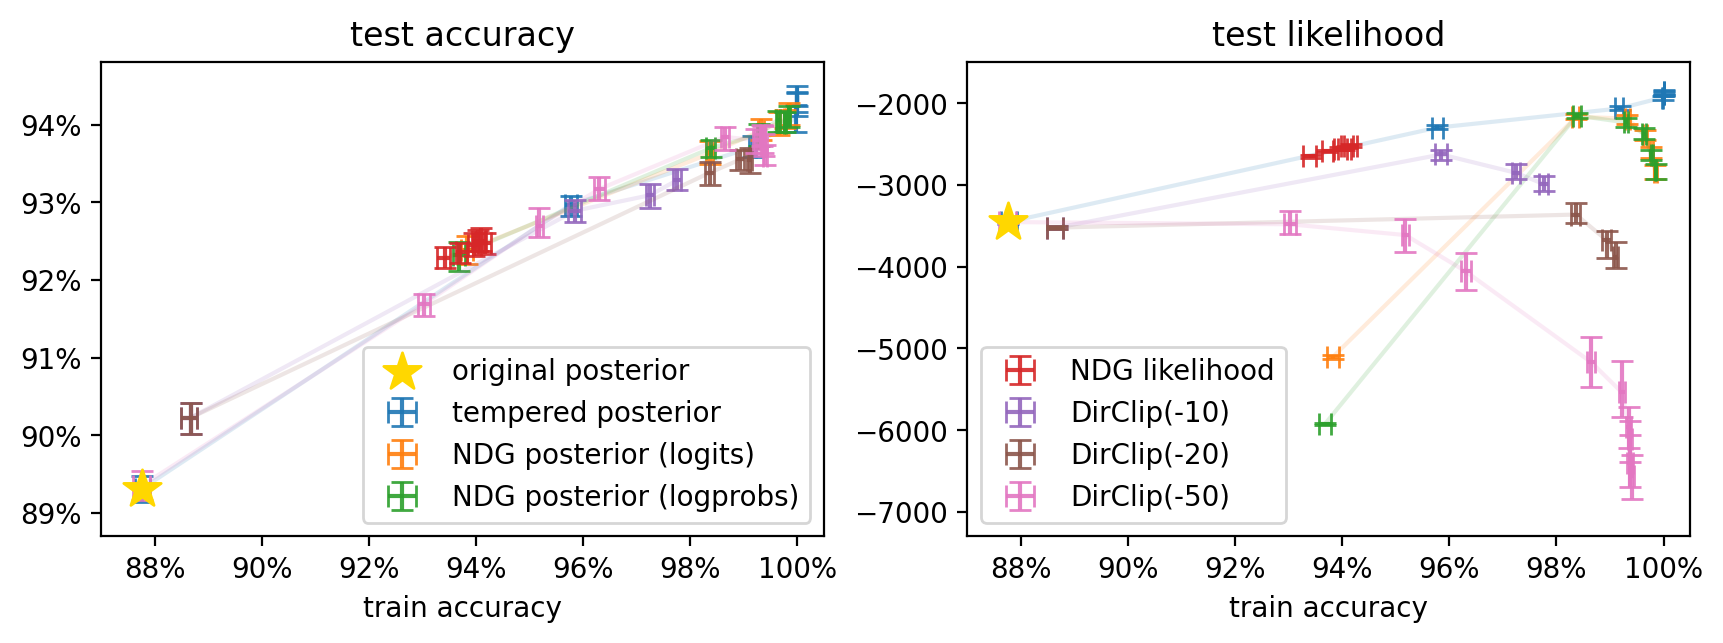

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(8.5, 3.1), layout='constrained')
x_metric = 'acc_train'

to_plot = (
    ('categorical', False, 'tempered posterior'),
    ('ndg-logits', False, 'NDG posterior (logits)'),
    ('ndg-logprobs', False, 'NDG posterior (logprobs)'),
    ('ndg-likelihood', False, 'NDG likelihood'),
    ('dirclip-10', True, 'DirClip(-10)'),
    ('dirclip-20', True, 'DirClip(-20)'),
    ('dirclip-50', False, 'DirClip(-50)'),
)

for ax, y_metric in zip(axs, ('acc_test', 'like_test')):

    # categorical baseline
    df_subset = df[(df.dist=='categorical') & (df.temp==1)]
    x = df_subset[x_metric].item()
    y = df_subset[y_metric].item()
    ax.scatter([x[0]], [y[0]], color='gold', marker='*', s=200, label='original posterior', zorder=100)
    # if y_metric == 'like_test':
    #    ax.axhline([y[0]], color='gold', ls='--', zorder=100, alpha=0.3)

    # other distributions
    for i, (distribution, finetuned, name) in enumerate(to_plot):
        df_subset = df[(df.dist==distribution) & (df.finetuned==finetuned)]
        if distribution == 'dirclip-50': df_subset = df_subset[df_subset.dist_param >= 0.83]
        o = np.argsort(df_subset[x_metric])
        x = np.stack(df_subset[x_metric])
        y = np.stack(df_subset[y_metric])
        color = f'C{i}'
        xerr = np.abs(x[o, :1] - x[o, 1:]).T
        yerr = np.abs(y[o, :1] - y[o, 1:]).T
        ax.errorbar(x[o, 0], y[o, 0], xerr=xerr, yerr=yerr, ls='', lw=1.5, alpha=0.9, capsize=4, label=name, color=color)
        ax.plot(x[o, 0], y[o, 0], lw=1.5, alpha=0.15, color=color)

for ax in axs: ax.set_xlim((0.87, 1.005))
axs[0].set_ylim((0.887, 0.948))
axs[1].set_ylim((-7_300, -1_500))
axs[0].xaxis.set_major_formatter(lambda x, _: f'{x:.1%}'.replace('.0', ''))
axs[1].xaxis.set_major_formatter(lambda x, _: f'{x:.1%}'.replace('.0', ''))
axs[0].yaxis.set_major_formatter(lambda x, _: f'{x:.1%}'.replace('.0', ''))
for ax in axs:
    ax.set_xlabel('train accuracy')
axs[0].set_title('test accuracy')
axs[1].set_title('test likelihood')

# legend (split across axes)
handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend(loc='lower right', handles=handles[:4])
axs[1].legend(loc='lower left', handles=handles[4:])

# plt.savefig('../plots/train_acc_vs_test_metrics.pdf')
plt.show()

# distribution of predicted logprobs

In [13]:
def load_logits(model_dir, split='train', n=None):
    dirs = glob(model_dir)
    if n is not None: dirs = sorted(dirs)[:n]
    return jnp.concatenate([jnp.load(f'{d}/logits_{split}.npy') for d in dirs])

logits_cold = load_logits(expanduser('~/Downloads/weights/weights_200_T0/*'), n=3)
logits_dirclip_rand_50 = load_logits(expanduser('~/Downloads/weights/weights_200_dirclip/*'), n=3)
logits_dirclip_pre_50 = load_logits(expanduser("~/Downloads/weights/weights_finetune_dirclip-50_50k/model='resnet20',ds='cifar10',dist='dirclip-50',dist_param=0.85,std=0.1,temp=1,augment=True,finetuned=True,seed=*"), n=3)
logits_dirclip_pre_10 = load_logits(expanduser("~/Downloads/weights/weights_misc/model='resnet20',ds='cifar10',dist='dirclip-10',dist_param=0.85,std=0.1,temp=1,augment=True,finetuned=True,seed=*"), n=3)

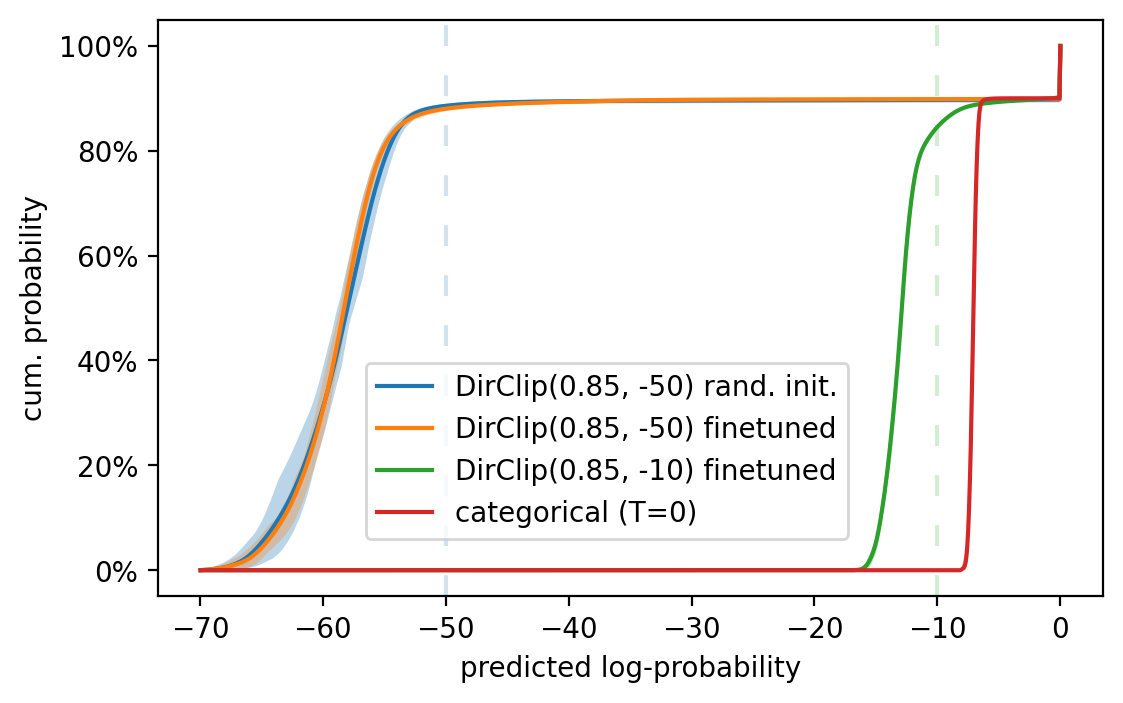

In [14]:
fig, ax = plt.subplots(figsize=(5.5, 3.4), layout='constrained')

to_plot = (
    ('DirClip(0.85, -50) rand. init.', logits_dirclip_rand_50),
    ('DirClip(0.85, -50) finetuned', logits_dirclip_pre_50),
    ('DirClip(0.85, -10) finetuned', logits_dirclip_pre_10),
    ('categorical (T=0)', logits_cold)
)

bins = jnp.linspace(-70, 0, 1_000)
for name, logits in to_plot:
    ls = '--' if name == 'DirClip(-50) finetuned' else '-'
    logprobs = jax.nn.log_softmax(logits) # [ens_size, n_test, n_class]
    freq, _ = vmap(partial(jnp.histogram, bins=bins))(logprobs) # [ens_size, n_bins]
    cdf = jnp.cumsum(freq, 1) / logprobs[0].size # [ens_size, n_bins]
    ax.plot(bins[1:], cdf.mean(0), label=name, ls=ls)
    ax.fill_between(bins[1:], jnp.quantile(cdf, 0.1, axis=0), jnp.quantile(cdf, 0.9, axis=0), alpha=0.3)

ax.axvline(-50, ls=(0, (5, 7)), c='C0', alpha=0.2)
ax.axvline(-10, ls=(0, (5, 7)), c='C2', alpha=0.2)
ax.yaxis.set_major_formatter(lambda x, _: f'{x:.0%}')
ax.set_xlabel('predicted log-probability')
ax.set_ylabel('cum. probability')
ax.legend(loc=(0.22, 0.1))
# plt.savefig('../plots/logprob_cdf.pdf')
plt.show()

# experiments on num. of posterior samples

In [15]:
logits_dir = load_logits(expanduser('~/Downloads/weights/weights_200_dirclip/*'), 'test')
logits_t0 = load_logits(expanduser('~/Downloads/weights/weights_200_T0/*'), 'test')
logits_t01 = load_logits(expanduser('~/Downloads/weights/weights_200_T01/*'), 'test')
(logits_dir.shape, logits_t0.shape, logits_t01.shape)

((200, 10000, 10), (200, 10000, 10), (200, 10000, 10))

## calibration

0 177350
1 0


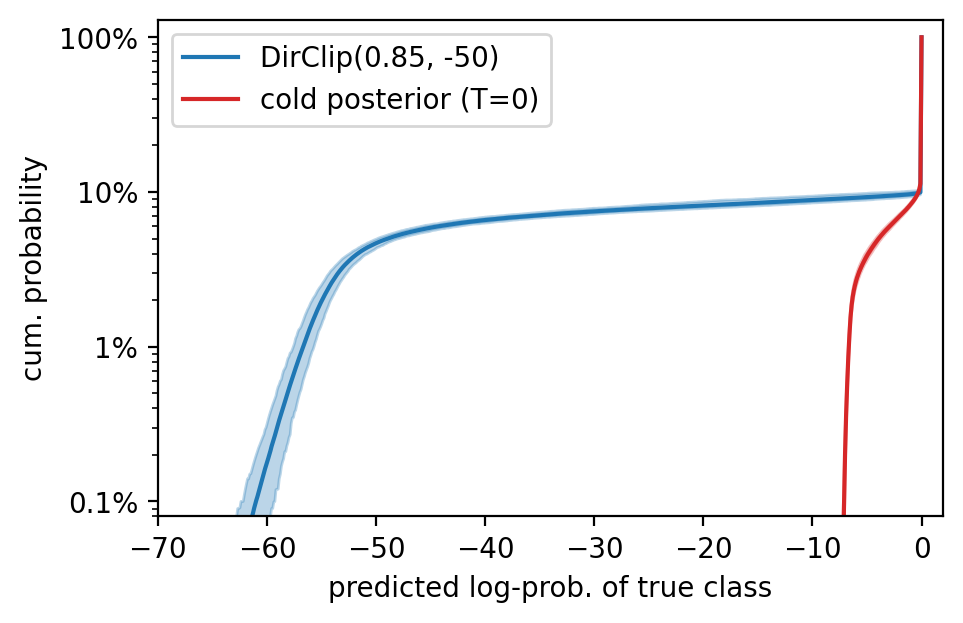

In [16]:
# histogram predicted log. probs.
fig, ax = plt.subplots(figsize=(4.7, 3), layout='constrained')
bins = jnp.linspace(-100, 0, 1_000)

to_plot = (
    ('DirClip(0.85, -50)', logits_dir, 'tab:blue'),
    ('cold posterior (T=0)', logits_t0, 'tab:red'),
)
for i, (name, logits, color) in enumerate(to_plot):
    
    logprobs = jax.nn.log_softmax(logits)
    ens_size, n_test, n_class = logprobs.shape
    logprobs = logprobs[jnp.arange(ens_size)[:, None], jnp.arange(n_test)[None, :], y_test[None, :]] # [ens_size, n_test]
    print(i, (logprobs < -10).sum())
    freq, _ = vmap(partial(jnp.histogram, bins=bins))(logprobs) # [ens_size, n_bins]
    cdf = jnp.cumsum(freq, 1) / logprobs[0].size # [ens_size, n_bins]
    ax.plot(bins[1:], cdf.mean(0), label=name, ls=ls, color=color)
    ax.fill_between(bins[1:], jnp.quantile(cdf, 0.1, axis=0), jnp.quantile(cdf, 0.9, axis=0), alpha=0.3, color=color)

ax.set_yscale('log')
ax.set_xlim((-70, 2))
ax.set_ylim((0.0008, 1.3))
ax.yaxis.set_major_formatter(lambda x, _: f'{100*x}%'.replace('.0%', '%'))
ax.legend()
ax.set_xlabel('predicted log-prob. of true class')
ax.set_ylabel('cum. probability')
# plt.savefig('../plots/logprob_true_class_cdf.pdf')
plt.show()

## test accuracy, likelihood

In [17]:
%%time
# for a given ordering of models, this fun. will return accuracy and likelihood for each ensemble size
def f(key, logits):
    n_samples = len(logits)
    logits_shuffled = jax.random.permutation(key, logits, axis=0) # [n_samples, n_test, n_class]
    probs = jax.nn.softmax(logits_shuffled) # [n_samples, n_test, n_class]
    probs = jnp.cumsum(probs, 0) / (1 + jnp.arange(len(probs)))[:, None, None] # [n_samples, n_test, n_class]
    logprobs = jnp.log(probs)
    y_one_hot = jax.nn.one_hot(y_test, n_class) # [n_test, n_class]
    acc = (logprobs.argmax(2) == y_test[None, :]).mean(1) # [n_samples]
    like = (logprobs * y_one_hot[None]).sum([1, 2]) # [n_samples]
    return acc, like

n_permutations = 20
key = jax.random.PRNGKey(0)
keys = jax.random.split(key, n_permutations)
acc_cold, like_cold = jax.lax.map(partial(f, logits=logits_t01), keys) # [n_permutations, ensemble_size]
acc_dir, like_dir = jax.lax.map(partial(f, logits=logits_dir), keys) # [n_permutations, ensemble_size]

CPU times: user 12.3 s, sys: 199 ms, total: 12.5 s
Wall time: 5.31 s


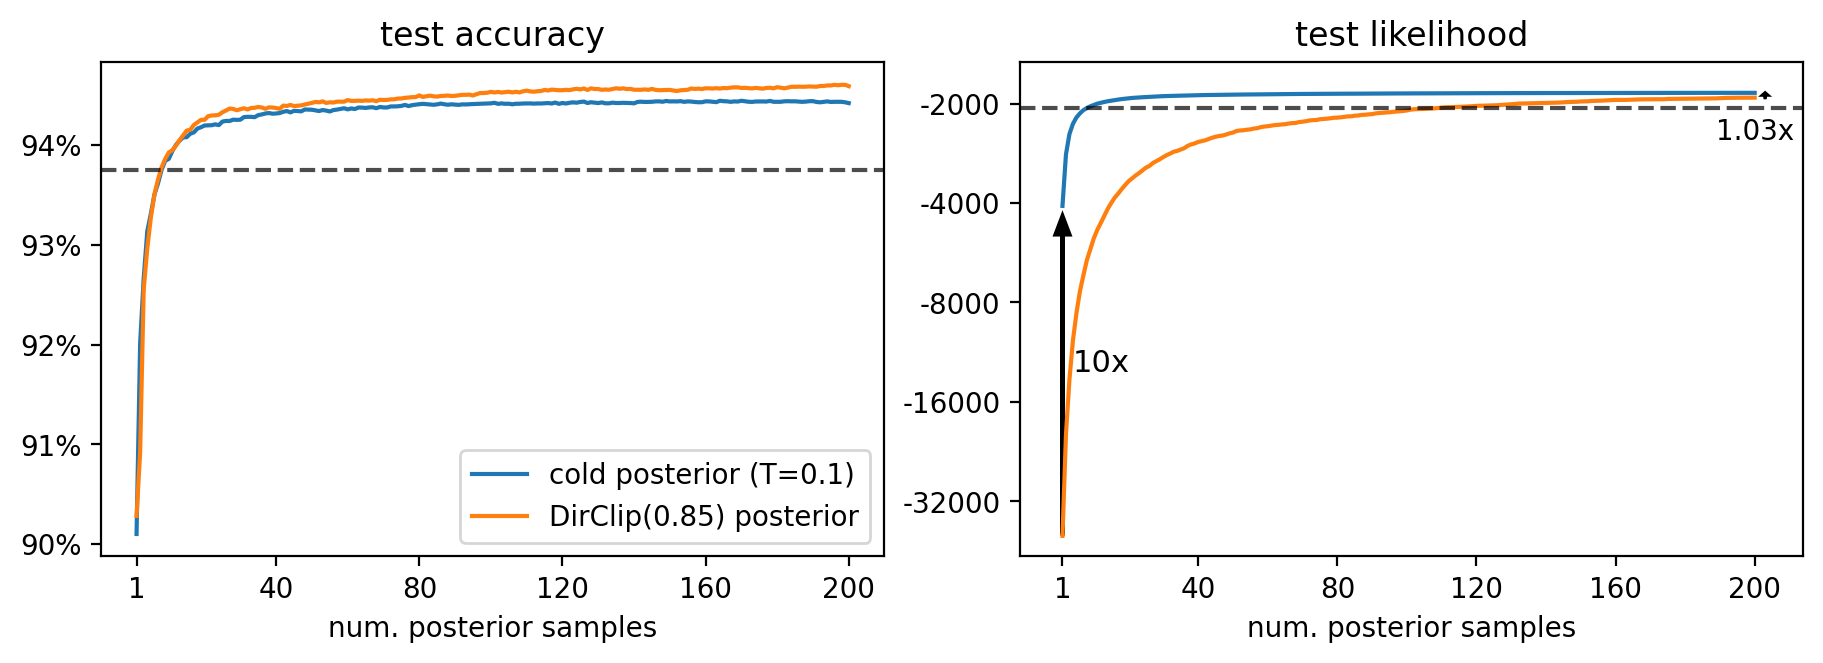

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3.2), layout='constrained')
n_samples = 8
n_plot = acc_cold.shape[1]
n = 1 + jnp.arange(n_plot)

# accuracy
for name, acc in (('cold posterior (T=0.1)', acc_cold), ('DirClip(0.85) posterior', acc_dir)):
    axs[0].plot(n, acc.mean(0), label=name)
axs[0].yaxis.set_major_formatter(lambda x, _: f'{x:.0%}')
axs[0].axhline(acc_cold[:, n_samples-1].mean(), ls='--', c='black', alpha=0.7)
axs[0].legend()

# likelihood
for like in (like_cold, like_dir):
    axs[1].plot(n, like.mean(0))
axs[1].set_ylim(-1500, -47_000)
axs[1].set_yscale(mpl.scale.FuncScale(ax, (lambda x: jnp.log(-x), lambda x: jnp.exp(x))))
axs[1].yaxis.set_major_formatter(lambda x, _: f'{x}')
axs[1].set_yticks([-2_000, -4_000, -8_000, -16_000, -32_000])
axs[1].axhline(like_cold[:, n_samples-1].mean(), ls='--', c='black', alpha=0.7)

# arrow: initial difference
y0 = like_dir[:, 0].mean()
y1 = like_cold[:, 0].mean()
axs[1].arrow(1, y0+600, 0, y1-y0-900, head_width=4, head_length=600, linewidth=1.5, color='black', length_includes_head=True)
# axs[1].arrow(1, y1-600, 0, y0-y1+1_200, head_width=4, head_length=4_000, linewidth=1.5, color='black', length_includes_head=True)
axs[1].text(4, -13_000, f'{(y0/y1):.0f}x', ha='left', fontsize=11)

# arrow: final difference
y0 = like_dir[:, -1].mean()
y1 = like_cold[:, -1].mean()
axs[1].arrow(n_plot+3, y0, 0, y1-y0, head_width=1.5, head_length=30, linewidth=1.2, color='black', length_includes_head=True)
axs[1].text(n_plot, -2_200, f'{(y0/y1):.2f}x', va='top', ha='center', fontsize=10)

axs[0].set_title('test accuracy')
axs[1].set_title('test likelihood')
for ax in axs:
    ax.set_xlabel('num. posterior samples')
    ax.set_xticks([1, 40, 80, 120, 160, 200])
# plt.savefig('../plots/ensemble_size.pdf')
plt.show()